In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import scipy.io as sio
import time

import models
import flows

In [2]:
data = sio.loadmat("data2.mat")
xx = data["xx"]
yy = data["yy"]
x = data["x"]
y = data["y"]
f = data["f"]
u = data["u"]

In [3]:
x_test = x
y_test = y
xx_test, yy_test = np.meshgrid(x_test, y_test)

x_train = x[:, ::2]
y_train = y[:, ::2]
xx_train, yy_train = np.meshgrid(x_train, y_train)
N = 2000
f_train = f[::2, ::2, :N]

In [4]:
x_train = xx_train.reshape([-1, 1])
y_train = yy_train.reshape([-1, 1])
f_train = f_train.reshape([-1, N])

In [5]:
meta_model = models.Meta(num_tasks=N, dim=50, eps=0.0)

In [6]:
t0 = time.time()
loss = meta_model.train(
    x_train, y_train, f_train, niter=20000, ftol=1e-6,
)
t1 = time.time()
print(t1 - t0)

0 0.02171824 0.02171824 , time:  2.1107447147369385
1000 6.585419e-05 6.585419e-05 , time:  11.665673971176147
2000 1.2977478e-05 1.2977478e-05 , time:  11.60469651222229
3000 7.213657e-06 7.213657e-06 , time:  11.594096183776855
4000 4.830406e-06 4.830406e-06 , time:  11.680192708969116
5000 3.5184821e-06 3.5184821e-06 , time:  11.89027452468872
6000 2.8293084e-06 2.8293084e-06 , time:  11.787116289138794
7000 2.1661663e-06 2.1661663e-06 , time:  11.74687647819519
8000 2.3336356e-06 2.3336356e-06 , time:  11.73081636428833
9000 1.6505719e-06 1.6505719e-06 , time:  12.26184344291687
10000 1.2735135e-06 1.2735135e-06 , time:  12.213165283203125
11000 1.0528718e-06 1.0528718e-06 , time:  11.66720724105835
12000 1.0245774e-06 1.0245774e-06 , time:  11.627707958221436
13000 9.0255065e-07 9.0255065e-07 , time:  11.552755355834961
155.50258612632751


In [7]:
# meta_model.restore()
loss[-1]

9.0255065e-07

In [8]:
out = meta_model.call(xx_test.reshape([-1, 1]), yy_test.reshape([-1, 1])).numpy()
out = out.reshape([101, 101, 2000])

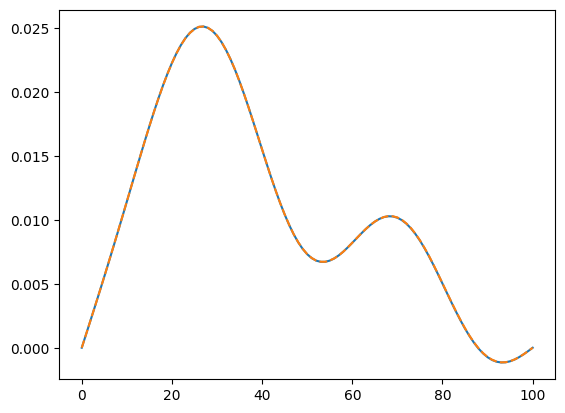

In [9]:
j = 10
i = 1000
plt.plot(u[j, :, i])
plt.plot(out[j, :, i], '--')
plt.show()

In [10]:
L2 = np.sqrt(np.sum(np.sum((out - u[..., :N])**2, axis=0), axis=0) / np.sum(np.sum(u[..., :N]**2, axis=0), axis=0))

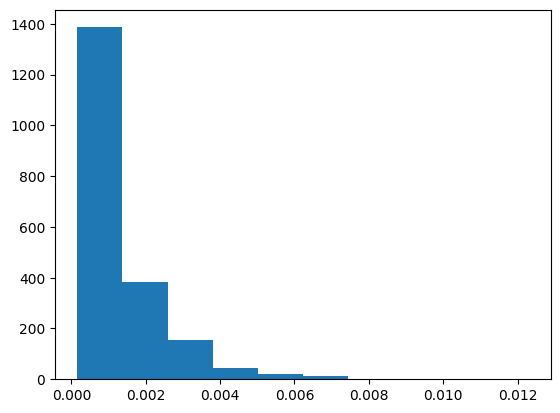

In [11]:
plt.hist(L2)
plt.show()

In [12]:
np.mean(L2), np.std(L2)

(0.0013140871, 0.001104267)

#### Normalizing flows

In [13]:
# xi = meta_model.xi.numpy()
permutation = list(np.arange(26, 51, 1)) + list(np.arange(0, 26, 1))
# permutation = list(np.arange(33, 65, 1)) + list(np.arange(0, 33, 1))

nf = flows.MAF(
    dim=51, 
    permutation=permutation,
    hidden_layers=[128, 128, 128, 128],
    num_bijectors=10,
    activation=tf.nn.relu,
)

In [14]:
xi = meta_model.xi.numpy()
t2 = time.time()
loss = nf.train_batch(tf.constant(xi, tf.float32), nepoch=500)
t3 = time.time()

0 -23.947742
1 -49.463417
2 -60.938972
3 -75.43351
4 -89.760506
5 -96.621376
6 -96.58178
7 -91.47044
8 -100.6804
9 -109.55913
10 -110.72925
11 -116.990204
12 -113.66443
13 -117.53198
14 -121.46068
15 -124.28781
16 -120.5632
17 -127.88594
18 -109.465675
19 -122.44011
20 -120.22884
21 -127.63522
22 -113.86356
23 -125.84928
24 -119.78873
25 -128.39507
26 -124.44512
27 -131.23476
28 -133.63147
29 -130.64912
30 -128.43175
31 -139.2003
32 -132.85802
33 -138.51054
34 -131.38394
35 -138.44736
36 -131.3879
37 -133.99419
38 -141.9783
39 -134.18726
40 -141.89713
41 -114.4979
42 -125.379944
43 -136.37411
44 -129.703
45 -140.89531
46 -141.88127
47 -137.1261
48 -144.59375
49 -141.66202
50 -141.99757
51 -145.54126
52 -147.24335
53 -131.22992
54 -149.00658
55 -141.34377
56 -146.8081
57 -144.234
58 -148.10934
59 -136.9587
60 -143.53003
61 -153.32657
62 -138.55731
63 -147.89774
64 -144.54968
65 -153.16437
66 -139.85927
67 -147.74565
68 -142.8414
69 -148.29138
70 -129.63658
71 -147.28928
72 -153.50496
73

In [17]:
# print(t3 - t2)
# print("Elapsed over phase 2: ", t2 - t1)
# print("Total training time: ", t2 - t0)
nf.restore()
sample_fn = tf.function(nf.sample)
xi_samples = sample_fn(2000)
x_test = tf.constant(x_train, tf.float32)
y_test = tf.constant(y_train, tf.float32)

In [18]:
basis = meta_model.shared_nn(tf.concat([x_test, y_test], axis=-1))
xi = tf.transpose(xi_samples)
u_pred = x_test * (1-x_test) * y_test * (1-y_test) * (tf.matmul(basis, xi[:50]) + xi[50:])
u_pred = tf.reshape(u_pred, [51, 51, N])
u_pred = tf.transpose(u_pred, [2, 0, 1])

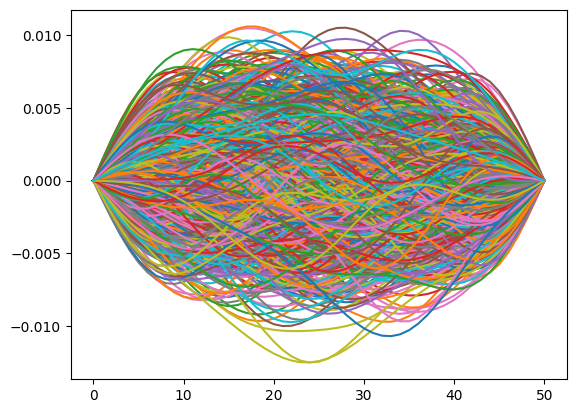

In [19]:
for i in range(1000):
    plt.plot(u_pred[i, :, 1])
# plt.ylim([-0.003, 0.003])

In [20]:
u_pred.shape

TensorShape([2000, 51, 51])

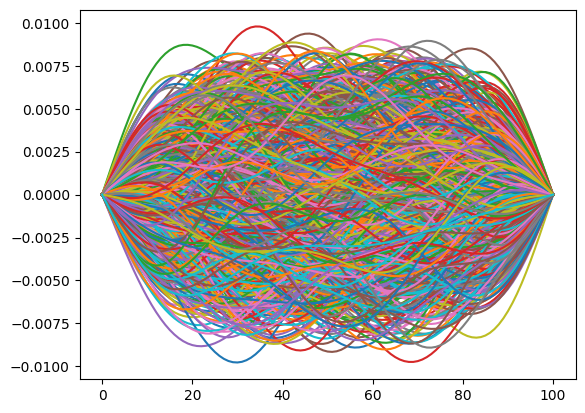

In [21]:
u_ref = tf.transpose(u, [2, 0, 1])
for i in range(1000):
    plt.plot(u_ref[i, :, 2*1])
# plt.ylim([-0.003, 0.003])

#### NeuralUQ

In [119]:
# data = sio.loadmat("data2.mat")
# xx = data["xx"]
# yy = data["yy"]
# f = data["f"]
# u = data["u"]
# x = data["x"][:, ::2]
# y = data["y"][:, ::2]
# x, y = np.meshgrid(x, y)

# u_test = u[..., -1]
# f_test = f[..., -1]
# idx = np.random.choice(51*51, 51*51, replace=False)
# x_train = x.reshape([-1, 1])[idx]
# y_train = y.reshape([-1, 1])[idx]
# f_train = f_test.reshape([-1, 1])[idx]
# f_train = f_train + 0.05 * np.random.normal(size=f_train.shape)

# sio.savemat(
#     "downstream.mat", 
#     {
#         "x_test": x,
#         "y_test": y,
#         "f_test": f_test,
#         "u_test": u_test,
#         "x_train": x_train,
#         "y_train": y_train,
#         "f_train": f_train,
#     }
# )

In [120]:
data = sio.loadmat("downstream.mat")
x_test = data["x_test"]
y_test = data["y_test"]
f_test = data["f_test"]
u_test = data["u_test"]
x_train = data["x_train"]
y_train = data["y_train"]
f_train = data["f_train"]

In [121]:
import neuraluq as neuq

In [122]:
class Samplable(neuq.variables._Samplable):
    
    def __init__(self, nf):
        super().__init__()
        self._num_tensors = 1
        self._initial_values = [tf.function(nf.sample)([])]
        self.log_prob_fn = tf.function(nf.log_prob)
    
    def log_prob(self, samples):
        return self.log_prob_fn(samples[0])
    

class Surrogate(neuq.surrogates.Surrogate):
    
    def __init__(self, meta_model):
        self.meta_model = meta_model
        
    def __call__(self, inputs, var_list):
        x, y = tf.split(inputs, 2, axis=-1)
        xi = tf.reshape(var_list[0], [-1, 51])
        sample_size = xi.shape[0]
        batch_size = inputs.shape[0]
        if sample_size == 1:
            # inputs is of (batch_size, dim_x), outputs is of (batch_size, dim_y)
            shared = self.meta_model.shared_nn.call(inputs) # shape of [batch_size, dim]
            out = tf.matmul(shared, tf.transpose(xi[..., :50])) + tf.transpose(xi[..., 50:])
            out = x * (1 - x) * y * (1 - y) * out
        else:
            # outputs is of (sample_size, batch_size, dim_x), so the inputs should be
            # of (sample_size, batch_size, dim_x), compared to its original shape:
            # (batch_size, dim_x)
            print(inputs.shape)
            #inputs = tf.tile(inputs[None, ...], [sample_size, 1, 1])
            shared = self.meta_model.shared_nn.call(tf.reshape(inputs, [-1, 1])) # shape in [sample_size * batch_size, dim]
            shared = tf.reshape(shared, [sample_size, batch_size, -1])
            out = tf.einsum("SBj,Sj->SB", shared, xi[..., :50]) + xi[..., 50:]
            out = x * (1 - x) * y * (1 - y) * out[..., None]
        return out
    
    
def pde_fn(inputs, u_fn):
    u = u_fn(inputs)
    u_x, u_y = tf.split(tf.gradients(u, inputs)[0], 2, axis=-1)
    u_xx = tf.gradients(u_x, inputs)[0][:, 0:1]
    u_yy = tf.gradients(u_y, inputs)[0][:, 1:2]
    f = 0.1 * (u_xx + u_yy) + u * (u**2 - 1)
    return f

In [123]:
prior = Samplable(nf)
surrogate = Surrogate(meta_model)
process = neuq.process.Process(surrogate=surrogate, prior=prior)

likelihood = neuq.likelihoods.Normal(
    inputs=np.concatenate([x_train, y_train], axis=-1), 
    targets=f_train, 
    sigma=0.05, 
    processes=[process],
    equation=pde_fn,
)

model = neuq.models.Model(
    processes=[process], likelihoods=[likelihood],
)

Supporting backend tensorflow



In [124]:
method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.01,
    leapfrog_step=50,
    seed=6666,
)
model.compile(method)

Compiling a MCMC method



In [ ]:
t0 = time.time()
samples, results = model.run()
t1 = time.time()
print("Acceptance rate: %.3f \n"%(np.mean(results)))  # if HMC is used
print("Elapsed of HMC: ", t1 - t0)

sampling from posterior distribution ...



In [78]:
inputs = tf.constant(
    np.concatenate([x_test.reshape([-1, 1]), y_test.reshape([-1, 1])], axis=-1),
    tf.float32,
)
basis = meta_model.shared_nn(inputs)
xi = tf.transpose(samples[0])
u_pred = inputs[:, 0:1] * (1-inputs[:, 0:1]) * inputs[:, 1:2] * (1-inputs[:, 1:2]) * (tf.matmul(basis, xi[:50]) + xi[50:])
u_pred = tf.reshape(u_pred, [51, 51, 1000])
u_pred = tf.transpose(u_pred, [2, 0, 1]).numpy()

_inputs = tf.tile(inputs[None, ...], [1000, 1, 1])

In [79]:
with tf.GradientTape() as g_xx, tf.GradientTape() as g_yy:
    g_xx.watch(_inputs)
    g_yy.watch(_inputs)
    with tf.GradientTape() as g_x, tf.GradientTape() as g_y:
        g_x.watch(_inputs)
        g_y.watch(_inputs)
        basis = meta_model.shared_nn(_inputs)
        xi = samples[0]
        out = tf.einsum("Nik,Nk->Ni", basis, xi[:, :50]) + xi[:, 50:]
        u_pred = _inputs[..., 0] * (1-_inputs[..., 0]) * _inputs[..., 1] * (1 - _inputs[..., 1]) * out
    u_x, u_y = tf.split(g_x.gradient(u_pred, _inputs), 2, axis=-1)
u_xx = g_xx.gradient(u_x, _inputs)[..., 0:1]
u_yy = g_yy.gradient(u_y, _inputs)[..., 1:2]
# u_pred = inputs[..., 0:1] * (1-inputs[..., 0:1]) * inputs[..., 1:2] * (1-inputs[..., 1:2]) * (tf.matmul(basis, xi[:50]) + xi[50:])

In [87]:
f_pred = 0.1 * (u_xx + u_yy)[..., 0] + u_pred*(u_pred**2 - 1)
f_pred = f_pred.numpy()
mu_f = np.mean(f_pred, axis=0).reshape([51, 51])
std_f = np.std(f_pred, axis=0).reshape([51, 51])

u_pred = u_pred.numpy()
mu_u = np.mean(u_pred, axis=0).reshape([51, 51])
std_u = np.std(u_pred, axis=0).reshape([51, 51])

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [88]:
mu_f.shape

(51, 51)

In [89]:
u_pred.shape

(1000, 2601)

In [107]:
sio.savemat(
    "downstream_results.mat",
    {
        "x_test": x_test,
        "y_test": y_test,
        "mu_u": mu_u,
        "std_u": std_u,
        "mu_f": mu_f,
        "std_f": std_f,
        "u_exact": u_test,
        "f_exact": f_test,
        "x_train": x_train,
        "y_train": y_train,
        "f_train": f_train,
    }
)

In [108]:
f_test.shape

(101, 101)

In [112]:
f_test.shape

(101, 101)

In [113]:
mu_f.shape

(51, 51)

(-0.5, 0.5)

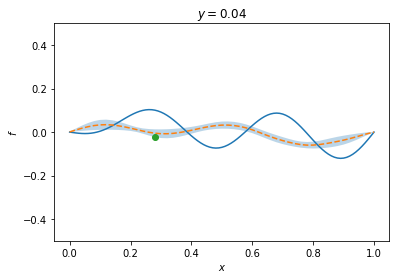

In [117]:
i = 2
x_train[y_train == y_test[i, 0]]
plt.plot(np.linspace(0, 1, 101), f_test[2*i, :])
plt.plot(np.linspace(0, 1, 51), mu_f[i, :], '--')
plt.fill_between(np.linspace(0, 1, 51), (mu_f + 2*std_f)[i, :], (mu_f - 2*std_f)[i, :], alpha=0.3)
plt.plot(x_train[y_train == y_test[2*i, 0]], f_train[y_train == y_test[2*i, 0]], 'o')
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.title("$y=$"+str(y_test[i, 0]))
plt.ylim([-0.5, 0.5])

(-0.01, 0.01)

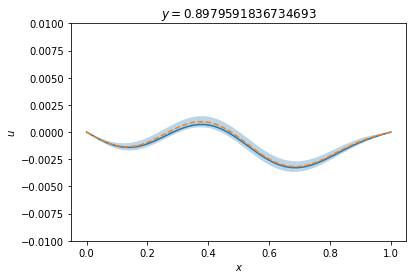

In [38]:
i = 44
plt.plot(x_test[i, :], u_test[i, :])
plt.plot(x_test[i, :], mu_u[i, :], '--')
plt.fill_between(x_test[i, :], (mu_u + 2*std_u)[i, :], (mu_u - 2*std_u)[i, :], alpha=0.3)
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.title("$y=$"+str(y_test[i, 0]))
plt.ylim([-0.01, 0.01])

#### Meta-learning

In [88]:
data = sio.loadmat("data2.mat")
xx = data["xx"]
yy = data["yy"]
f = data["f"]
u = data["u"]
x = data["x"][:, ::2]
y = data["y"][:, ::2]
x, y = np.meshgrid(x, y)

u_test = u[..., -1]
f_test = f[..., -1]
x_test = data["x"]
y_test = data["y"]

np.random.seed(4321)
idx = np.random.choice(51*51, 51*51, replace=False)[:50]
x_train = x.reshape([-1, 1])[idx]
y_train = y.reshape([-1, 1])[idx]
f_train = f_test[::2, ::2].reshape([-1, 1])[idx]
# f_train = f_train + 0.05 * np.random.normal(size=f_train.shape)

# sio.savemat(
#     "downstream.mat", 
#     {
#         "x_test": x,
#         "y_test": y,
#         "f_test": f_test,
#         "u_test": u_test,
#         "x_train": x_train,
#         "y_train": y_train,
#         "f_train": f_train,
#     }
# )

In [89]:
new_model = Model(body=meta_model, flow=nf, dim=50, eps=1e-5)

In [90]:
loss = new_model.train(
    inputs_f=np.concatenate([x_train, y_train], axis=-1),
    targets_f=f_train,
    niter=10000,
)

0 0.16508195
1000 0.0001271835
2000 -0.0016647554
3000 -0.00200168
4000 -0.002025833
5000 -0.0020265302
6000 -0.0020265353
7000 -0.002026518
8000 -0.0020265346
9000 -0.0020263304


In [163]:
f_train.shape

(50, 1)

In [164]:
np.concatenate([x_train, y_train], axis=-1).shape

(50, 2)

In [91]:
xx_test, yy_test = np.meshgrid(x_test, y_test)
u_pred = new_model.call(
    tf.constant(np.concatenate([xx_test.reshape([-1, 1]), yy_test.reshape([-1, 1])], axis=-1), tf.float32)
).numpy()
u_pred = u_pred.reshape([101, 101])

In [92]:
np.sqrt(np.sum((u_pred - u_test).flatten() ** 2) / np.sum(u_test.flatten() ** 2))

0.0017685104

In [95]:
f_pred = new_model.pde(
    tf.constant(np.concatenate([xx_test.reshape([-1, 1]), yy_test.reshape([-1, 1])], axis=-1), tf.float32)
).numpy()
f_pred = f_pred.reshape([101, 101])

In [117]:
sio.savemat(
    "results.mat",
    {
        "u_test": u_test,
        "u_pred": u_pred,
        "x_test": x_test,
        "y_test": y_test,
        "x_train": x_train,
        "y_train": y_train,
        "f_train": f_train,
        "f_test": f_test,
        "f_pred": f_pred,
    }
)

In [124]:
y_train == y_test[0, 30]

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False]])

In [128]:
x_train[y_train == y_test[0, 0]]

array([0.68, 0.24])

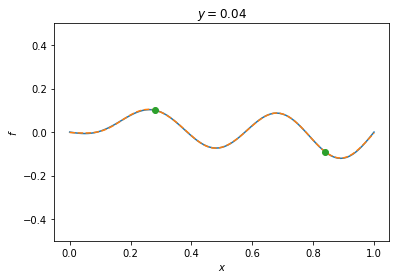

In [173]:
i = 4
plt.plot(x_test[0, :], f_test[i, :])
plt.plot(x_test[0, :], f_pred[i, :], '--')
plt.plot(x_train[y_train == y_test[0, i]], f_train[y_train == y_test[0, i]], 'o')
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.title("$y=$"+str(y_test[0, i]))
plt.ylim([-0.5, 0.5])
plt.savefig("./figures/f_1.png")

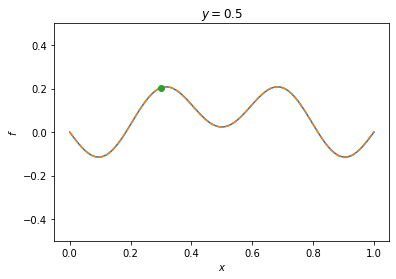

In [171]:
i = 50
plt.plot(x_test[0, :], f_test[i, :])
plt.plot(x_test[0, :], f_pred[i, :], '--')
plt.plot(x_train[y_train == y_test[0, i]], f_train[y_train == y_test[0, i]], 'o')
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.title("$y=$"+str(y_test[0, i]))
plt.ylim([-0.5, 0.5])
plt.savefig("./figures/f_2.png")

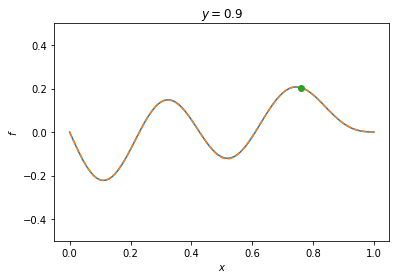

In [172]:
i = 90
plt.plot(x_test[0, :], f_test[i, :])
plt.plot(x_test[0, :], f_pred[i, :], '--')
plt.plot(x_train[y_train == y_test[0, i]], f_train[y_train == y_test[0, i]], 'o')
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.title("$y=$"+str(y_test[0, i]))
plt.ylim([-0.5, 0.5])
plt.savefig("./figures/f_3.png")

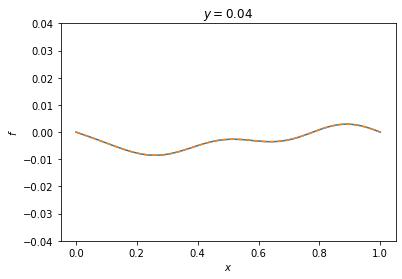

In [168]:
i = 4
plt.plot(x_test[0, :], u_test[i, :])
plt.plot(x_test[0, :], u_pred[i, :], '--')
# plt.plot(x_train[y_train == y_test[0, i]], f_train[y_train == y_test[0, i]], 'o')
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.title("$y=$"+str(y_test[0, i]))
plt.ylim([-0.04, 0.04])
plt.savefig("./figures/u_1.png")

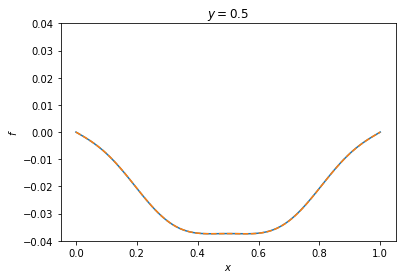

In [169]:
i = 50
plt.plot(x_test[0, :], u_test[i, :])
plt.plot(x_test[0, :], u_pred[i, :], '--')
# plt.plot(x_train[y_train == y_test[0, i]], f_train[y_train == y_test[0, i]], 'o')
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.title("$y=$"+str(y_test[0, i]))
plt.ylim([-0.04, 0.04])
plt.savefig("./figures/u_2.png")

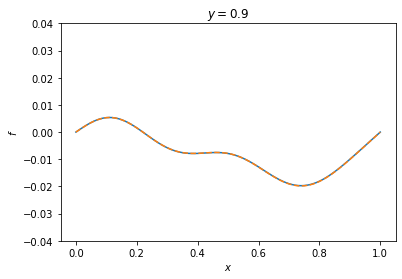

In [170]:
i = 90
plt.plot(x_test[0, :], u_test[i, :])
plt.plot(x_test[0, :], u_pred[i, :], '--')
# plt.plot(x_train[y_train == y_test[0, i]], f_train[y_train == y_test[0, i]], 'o')
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.title("$y=$"+str(y_test[0, i]))
plt.ylim([-0.04, 0.04])
plt.savefig("./figures/u_3.png")

In [100]:
f_test.shape

(101, 101)

In [46]:
u_pred.shape

TensorShape([10201, 1])

In [27]:
f_train.shape

(2601, 1)

In [28]:
u.shape

(101, 101, 10000)

In [29]:
f.shape

(101, 101, 10000)

In [87]:
class Model(tf.keras.Model):

    def __init__(self, body, flow, dim, eps=0.1):
        super().__init__()
        self.body = body
        self.log_prob_fn = tf.function(flow.log_prob)
        self.sample_fn = tf.function(flow.sample)
        self.dim = dim
        
        #init = self.sample_fn([1])
        init = 0.05 * tf.random.normal(shape=[1, 51])
        self.head = tf.Variable(tf.transpose(init))
        self.eps = eps

        self.opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    def call(self, inputs):
        basis = self.body.shared_nn(inputs)
        return inputs[:, 0:1] * (1 - inputs[:, 0:1]) * inputs[:, 1:2] * (1 - inputs[:, 1:2]) * (tf.matmul(basis, self.head[:self.dim]) + self.head[self.dim:])

    def loss_function(self, inputs_f, targets_f):
        u = self.call(inputs_f)
        u_x, u_y = tf.split(tf.gradients(u, inputs_f)[0], 2, axis=-1)
        u_xx = tf.gradients(u_x, inputs_f)[0][:, 0:1]
        u_yy = tf.gradients(u_y, inputs_f)[0][:, 1:2]
        f_pred = 0.1 * (u_xx + u_yy) + u * (u ** 2 - 1)
        return tf.reduce_mean((f_pred - targets_f) ** 2)
    
    @tf.function
    def pde(self, inputs):
        u = self.call(inputs)
        u_x, u_y = tf.split(tf.gradients(u, inputs)[0], 2, axis=-1)
        u_xx = tf.gradients(u_x, inputs)[0][:, 0:1]
        u_yy = tf.gradients(u_y, inputs)[0][:, 1:2]
        return 0.1 * (u_xx + u_yy) + u * (u ** 2 - 1)
    
    @tf.function
    def train_op(self, inputs_f, targets_f):
        with tf.GradientTape() as tape:
            regularization = - tf.math.reduce_sum(self.log_prob_fn(tf.transpose(self.head)))
            losses = self.loss_function(inputs_f, targets_f) 
            total_loss = tf.reduce_sum(losses) + self.eps * regularization
        grads = tape.gradient(total_loss, [self.head])
        self.opt.apply_gradients(zip(grads, [self.head]))
        return total_loss

    def train(self, inputs_f, targets_f, niter=10000):
        inputs_f = tf.constant(inputs_f, tf.float32)
        targets_f = tf.constant(targets_f, tf.float32)

        train_op = self.train_op

        min_loss = 1000
        loss = []

        for it in range(niter):
            loss_value = train_op(inputs_f, targets_f)
            loss += [loss_value.numpy()]
            if it % 1000 == 0:
                print(it, loss[-1])
                if loss_value < min_loss and it > niter//2:
                    min_loss = loss_value
                    self.save_weights(
                        filepath="./checkpoints/model",
                        overwrite=True,
                    )

        return loss

    def restore(self):
        self.load_weights("./checkpoints/model")